## Animal Classifier
Training an image classification using pytorch

In [20]:
import os
from pathlib import Path

import torch, torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

print(f"Pytorch version: {torch.__version__}")

Pytorch version: 2.1.1


### SETUP

In [21]:
# GPU or CPU?
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### DATASET
Load and clean the dataset:
1. Make sure the animals dataset is downloaded into the "datasets/animals" directory
   (https://www.kaggle.com/datasets/npurav/animal-classification-dataset)
2. Add augmented images to the dataset.
3. Load the dataset then split into train and test data

In [22]:
# Get root directory
BASE_DIR = Path.cwd().resolve().parent.parent

# Path to your dataset
dataset_path = BASE_DIR / 'datasets/animals/dataset'

# Define transformations (you can customize these based on your needs)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),
])

# Create ImageFolder dataset
dataset = ImageFolder(dataset_path, transform=transform)
class_names = dataset.classes

In [23]:
# Image augmentation
# Define image transformations for augmentation
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(), # Random vertical flip
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Apply augmentation to the entire dataset
augmented_dataset = ImageFolder(dataset_path, transform=augmentation_transform)

# Combine the original and augmented datasets
dataset = torch.utils.data.ConcatDataset([dataset, augmented_dataset])
print(f'Total number of images: {len(dataset)}')

Total number of images: 41248


In [24]:
# Split the dataset into training and testing sets
# Change the split ratio as needed (e.g., test_size=0.2 for an 80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [25]:
# Create data loaders
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

Display a subset of the training images

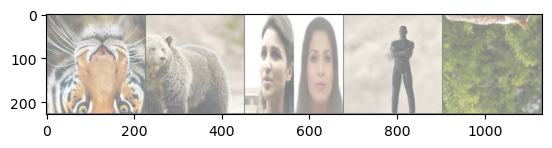

panthera-tigris ursus-arctos-horribilis homo-sapiens homo-sapiens acinonyx-jubatus
CPU times: user 769 ms, sys: 153 ms, total: 922 ms
Wall time: 23.1 s


In [26]:
%%time

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:5]))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

### TRAINING STEP
Define a convolution neural network

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 32, 5)
        # self.fc1 = nn.Linear(32 * 5 * 5, 400)
        self.fc1 = nn.Linear(89888, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=151, bias=True)
)

Define loss function and optimizer

In [28]:
learning_rate = 0.0006

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Train the network

In [30]:
%%time
epochs = 11
print('Starting Training...')
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = 50
        if i % step == step - 1:    # print after ever "step" mini-batches
            print(f'epoch({epoch + 1}/{epochs}) batch: {i + 1} loss: {running_loss / step:.3f}')
            running_loss = 0.0

print('Finished Training')

Starting Training...
epoch(1/11) batch: 100 loss: 1.607
epoch(1/11) batch: 200 loss: 1.589
epoch(2/11) batch: 100 loss: 1.544
epoch(2/11) batch: 200 loss: 1.547
epoch(3/11) batch: 100 loss: 1.497
epoch(3/11) batch: 200 loss: 1.498
epoch(4/11) batch: 100 loss: 1.492
epoch(4/11) batch: 200 loss: 1.473
epoch(5/11) batch: 100 loss: 1.425
epoch(5/11) batch: 200 loss: 1.445
epoch(6/11) batch: 100 loss: 1.441
epoch(6/11) batch: 200 loss: 1.408
epoch(7/11) batch: 100 loss: 1.418
epoch(7/11) batch: 200 loss: 1.398
epoch(8/11) batch: 100 loss: 1.363
epoch(8/11) batch: 200 loss: 1.390
epoch(9/11) batch: 100 loss: 1.345
epoch(9/11) batch: 200 loss: 1.354
epoch(10/11) batch: 100 loss: 1.340
epoch(10/11) batch: 200 loss: 1.361
epoch(11/11) batch: 100 loss: 1.322
epoch(11/11) batch: 200 loss: 1.363
Finished Training
CPU times: user 23.4 s, sys: 9.45 s, total: 32.9 s
Wall time: 2h 31s


In [37]:
PATH = BASE_DIR / 'models/ac_py.pth'
torch.save(net.state_dict(), PATH)

### TESTING
Test the trained network on test data

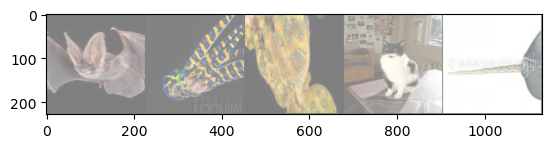

GroundTruth:  desmodus-rotundus hapalochlaena-maculosa hapalochlaena-maculosa felis-catus monodon-monoceros
CPU times: user 532 ms, sys: 89.2 ms, total: 621 ms
Wall time: 13.3 s


In [38]:
%%time

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[0:5]))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

In [39]:
# Load the trained model
PATH = BASE_DIR / 'models/ac_py.pth'

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Run tests on a subset of test data

In [40]:
%%time
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}' for j in range(5)))

Predicted:  vulpes-vulpes panthera-tigris ophiophagus-hannah felis-catus monodon-monoceros
CPU times: user 750 ms, sys: 407 ms, total: 1.16 s
Wall time: 332 ms


Run test on the entire test data

In [41]:
%%time
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        if inputs.size()[0] != batch_size:
            break
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 4 %
CPU times: user 45 s, sys: 21.3 s, total: 1min 6s
Wall time: 45.1 s


Run test for each class

In [42]:
%%time
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
            
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: acinonyx-jubatus is 3.1 %
Accuracy for class: aethia-cristatella is 0.0 %
Accuracy for class: agalychnis-callidryas is 0.0 %
Accuracy for class: agkistrodon-contortrix is 0.0 %
Accuracy for class: ailuropoda-melanoleuca is 5.0 %
Accuracy for class: ailurus-fulgens is 0.0 %
Accuracy for class: alces-alces is 0.0 %
Accuracy for class: anas-platyrhynchos is 0.0 %
Accuracy for class: ankylosaurus-magniventris is 0.0 %
Accuracy for class: apis-mellifera is 0.0 %
Accuracy for class: aptenodytes-forsteri is 3.8 %
Accuracy for class: aquila-chrysaetos is 4.9 %
Accuracy for class: ara-macao is 0.0 %
Accuracy for class: architeuthis-dux is 0.0 %
Accuracy for class: ardea-herodias is 0.0 %
Accuracy for class: balaenoptera-musculus is 4.2 %
Accuracy for class: betta-splendens is 0.0 %
Accuracy for class: bison-bison is 5.0 %
Accuracy for class: bos-gaurus is 0.0 %
Accuracy for class: bos-taurus is 0.0 %
Accuracy for class: bradypus-variegatus is 0.0 %
Accuracy for class: branta